## Challenge: Implement the Nearest Neighbor algorithm 

Code a Nearest Neighbors algorithm that works for two dimensional data. You can use either arrays or dataframes to do this. Test it against the SKLearn package to ensure that it's correct. The goal here is to confirm your understanding of the model and continue to practice your Python skills. We're just expecting a brute force method here. After doing this, look up "ball tree" methods to see a more performant algorithm design.

### Choose and load a dataset
We'll be working with the weather dataset, used in previous models. Specifically, we'll be trying to predict the type of precipitation based on temperature and humidity.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')


postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# Use the connection to extract SQL data
weather_df = pd.read_sql_query('SELECT * FROM weatherinszeged', con=engine)

#Close the connection after query is complete
engine.dispose()

In [3]:
weather_df.columns

Index(['date', 'summary', 'preciptype', 'temperature', 'apparenttemperature',
       'humidity', 'windspeed', 'windbearing', 'visibility', 'loudcover',
       'pressure', 'dailysummary'],
      dtype='object')

### Visualize our variables of interest

In [33]:
#Simplify the dataset to only our variables of interest
weather = weather_df[['temperature','pressure','preciptype']]
weather.head()

,temperature,pressure,preciptype
0,9.472222,1015.13,rain
1,9.355556,1015.63,rain
2,9.377778,1015.94,rain
3,8.288889,1016.41,rain
4,8.755556,1016.51,rain


In [34]:
#List of preciptype categories:
print(list(np.unique(weather['preciptype'])))

#Drop null preciptype rows
weather = weather[weather['preciptype']!='null']

#New list of preciptype categories:
print(list(np.unique(weather['preciptype'])))

['null', 'rain', 'snow']
['rain', 'snow']


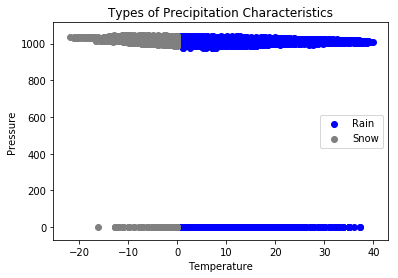

In [35]:
# Look at our data.
plt.scatter(
    weather[weather['preciptype'] == 'rain']['temperature'],
    weather[weather['preciptype'] == 'rain']['pressure'],
    color='blue'
)
plt.scatter(
    weather[weather['preciptype'] == 'snow']['temperature'],
    weather[weather['preciptype'] == 'snow']['pressure'],
    color='gray'
)

plt.legend(['Rain', 'Snow'])
plt.title('Types of Precipitation Characteristics')
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.show()

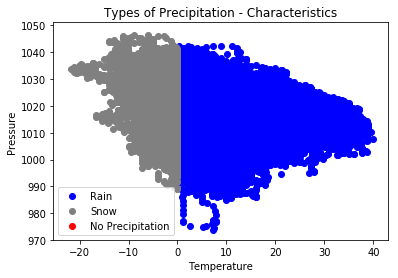

In [71]:
#Drop rows in which pressure is 0, because a pressure of 0 doesn't make physical sense
weather = weather[weather['pressure']>0]
weather = weather.reset_index(drop=True)

# Look at our data now that it has been fixed
plt.scatter(
    weather[weather['preciptype'] == 'rain']['temperature'],
    weather[weather['preciptype'] == 'rain']['pressure'],
    color='blue'
)
plt.scatter(
    weather[weather['preciptype'] == 'snow']['temperature'],
    weather[weather['preciptype'] == 'snow']['pressure'],
    color='gray'
)
plt.scatter(
    weather[weather['preciptype'] == 'null']['temperature'],
    weather[weather['preciptype'] == 'null']['pressure'],
    color='red'
)

plt.legend(['Rain', 'Snow', 'No Precipitation'])
plt.title('Types of Precipitation - Characteristics')
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.show()

### Nearest Neighbor Analysis

In [72]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=1)
X = weather[['temperature', 'pressure']]
Y = weather['preciptype']
neighbors.fit(X,Y)

## Predict for a song with 0 temperature and 1000 pressure
neighbors.predict([[0, 1000]])

array(['snow'], dtype=object)

### K-Nearest Neighbors

In [82]:
neighbors = KNeighborsClassifier(n_neighbors=1000)
X = weather[['temperature', 'pressure']]
Y = weather['preciptype']
neighbors.fit(X,Y)

## Predict for a song with 0 temperature and 1000 pressure
print(neighbors.predict([[0, 1000]]))
print(neighbors.predict_proba([[0, 1000]]))

['rain']
[[0.779 0.221]]


### Mesh Visualization

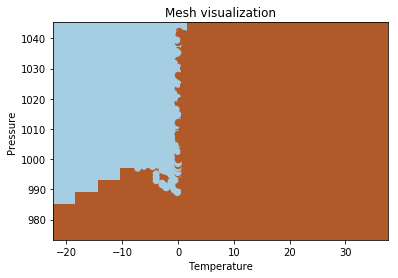

In [88]:
#Convert preciptype to 1 and 0
ptype = []
for i in range(len(Y)):
    if Y[i] == 'rain':
        ptype.append(1)
    elif Y[i] == 'snow':  
        ptype.append(0)
Y = ptype

neighbors = KNeighborsClassifier(n_neighbors=1000)
neighbors.fit(X,Y)

# Our data. Converting from data frames to arrays for the mesh.
X = np.array(X)
Y = np.array(Y)

# Mesh size.
h = 4.0

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

As the mesh visualization shows, based on this dataset, snow is generally most likely at temperatures of 0 or below, but if the pressure is low enough, rain will become more likely than snow. Although I think some of this is an issue of outliers, this does make some sense in that pressure and temperature are proportional (according to the ideal gas law), so it is logical that lowering the pressure allows the precipitation to reach a lower temperature without freezing. 